In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from tsfit import TSFit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def marketplot(symbol, mL, period, h=None, t0_date=None, forecast=0,
               start_date=None, end_date=None, plot_normal=True, plot_geo=True, file=None):
    '''Plots fitted curves for market data with or without geometric adjustment
    '''
    
    def prep_df(df, period, start_date, end_date, t0_date, forecast):
        # Currently, TSFit handles only data structures indexed by integers.
        # The pandas_datareader module retrieves data as pandas.DataFrame objects,
        # indexed by timestamps, not integers.
        # This prep function deals with setting up currect references of timestamps
        # and integer indices. Note that if dates entered by the user fall on a
        # weekend/holiday, the next/previous trading day is being used.
        # This function also adds dummy rows to df if a forecast into the future
        # is requested. The dummy rows are essential, so TSFit has index values
        # of the future to work with (the dummy prices are irrelevant and will
        # not be plotted).
        
        if start_date is None:
            # EWMAs need built-up time, so starting at index 0 is not adviced
            start_index = int(df.shape[0] / 3)
            start_date = df.index[start_index]
        else:
            start_date = df[start_date:].index[0]
            start_index = df.index.get_loc(start_date)
        
        if end_date is None:
            end_date = df.index[-1]
            end_index = df.shape[0] - 1
        else:
            end_date = df[:end_date].index[-1]
            end_index = df.index.get_loc(end_date)

        if t0_date is None:
            t0_index = end_index
            t0_date = end_date
        else:
            t0_date = df[:t0_date].index[-1]
            t0_index = df.index.get_loc(t0_date) #must be a valid market date, no weekends
            
        period_date = None
        if t0_index - period > 0:
            period_date = df.index[t0_index - period]
            if period_date <= start_date:
                period_date = None
            
        # if the forecast period goes past the end_date we must add dummy rows to the df
        lastplot_index = end_index
        if t0_index + forecast > end_index:
            lastdate = end_date
            for i in range(end_index + 1, t0_index + forecast + 1):
                lastdate = lastdate + pd.Timedelta(days=1)
                newrow = pd.DataFrame(df.iloc[df.shape[0]-1:,:])
                newrow.index = [lastdate]
                df = pd.concat([df, newrow])
            lastplot_index = df.shape[0] - 1
                
        datedict = {}
        datedict['startindex'] = start_index
        datedict['startdate'] = start_date
        datedict['endindex'] = end_index
        datedict['enddate'] = end_date
        datedict['t0index'] = t0_index
        datedict['t0date'] = t0_date
        datedict['lastfit'] = t0_index + forecast
        datedict['lastfitdate'] = df.index[t0_index + forecast]
        datedict['perioddate'] = period_date
        datedict['lastplotindex'] = lastplot_index
        
        return df, datedict
    

    symbol = str.upper(symbol)
    try:
        df = pdr.data.get_data_yahoo(symbol)
    except Exception:
        print('Invalid symbol:', symbol)
        return
    
    df, datedict = prep_df(df, period, start_date, end_date, t0_date, forecast)
    
    start_index = datedict['startindex']
    start_date = datedict['startdate']
    end_index = datedict['endindex']
    end_date = datedict['enddate']
    t0_index = datedict['t0index']
    t0_date = datedict['t0date']
    lastfit_index = datedict['lastfit']
    lastfit_date = datedict['lastfitdate']
    period_date = datedict['perioddate']
    lastplot_index = datedict['lastplotindex']
    
    # currently, TSFit works only with integer indices, hence all the complicated conversions
    plotdf = df.reset_index(drop=True)
    plotdf = plotdf[['Adj Close']]
    plotdf.columns = ['values'] # if using DataFrames, TSFit expects a "values" column
    
    for m in mL:
        if h is None:
            tsfit = TSFit(m, period=period)
            tsfit_geo = TSFit(m, period=period, rw_type='Geometric')
        else:
            tsfit = TSFit(m, h=h, period=period)
            tsfit_geo = TSFit(m, h=h, period=period, rw_type='Geometric')
        tsfit.fit(plotdf['values'])
        #at least on of plot_normal or plot_geo must be True
        if plot_normal:
            est = tsfit.transform(t0=t0_index)
            plotdf = plotdf.join(pd.DataFrame(est, columns=['m='+str(m)]), how='outer')
        if plot_geo:
            tsfit_geo.fit(plotdf['values'])
            estgeo = tsfit_geo.transform(t0=t0_index)
            plotdf = plotdf.join(pd.DataFrame(estgeo, columns=['m='+str(m)+'-geo']), how='outer')

    #plotdf = plotdf.iloc[start_index:lastplot_index+1] # integer index
    plotdf.index = df.index # time index
    
    plt.figure(figsize=(12, 8))
    plt.plot(plotdf['values'].loc[start_date:end_date], c='k')
    plt.plot(plotdf.iloc[start_index:lastfit_index+1,1:])
    plotdf = plotdf.rename(columns = {'values': symbol})
    plt.legend(plotdf.columns)
    if t0_index < lastplot_index:
        plt.axvline(t0_date, c='k')
    if period_date is not None:
        plt.axvline(period_date, c='k')
        
    if file is not None:
        plt.savefig(file, bbox_inches='tight')

Sample uses given below. 

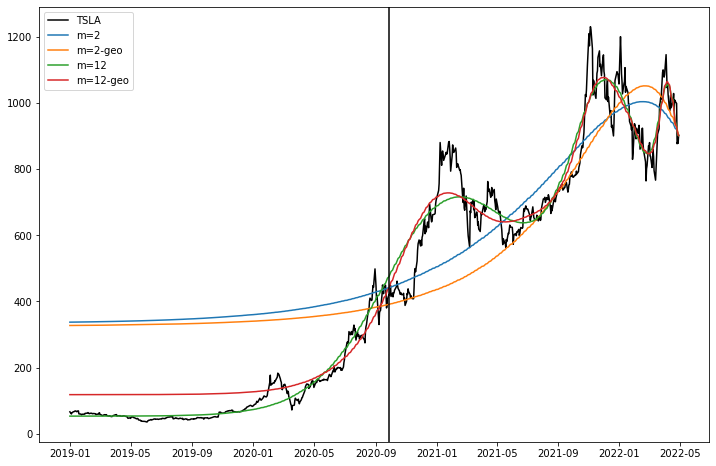

In [3]:
marketplot('tsla', [2, 12], period=400)

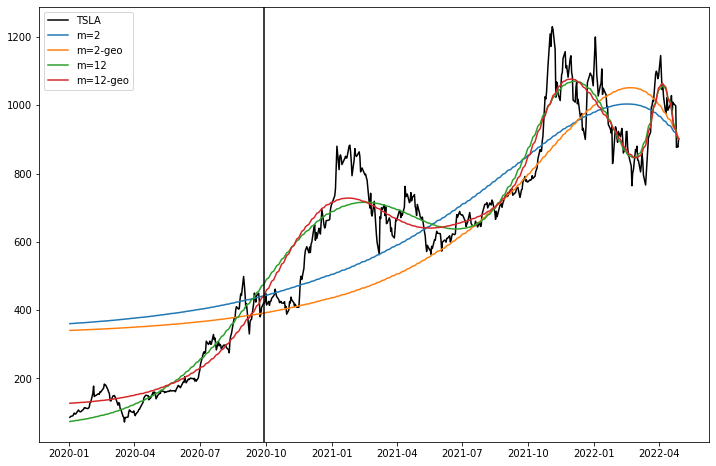

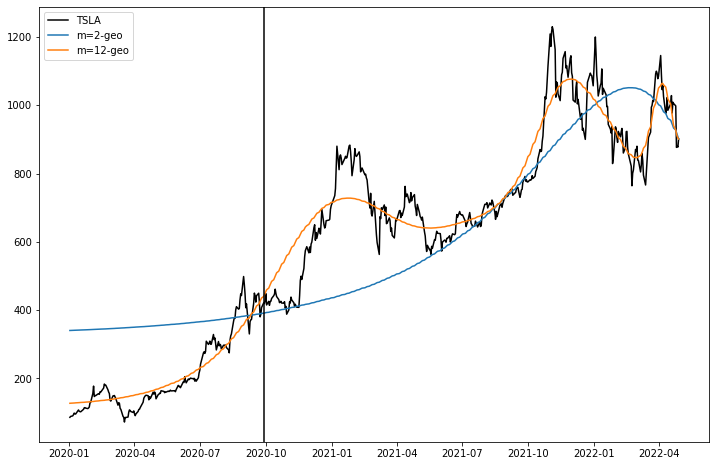

In [4]:
marketplot('tsla', [2, 12], period=400, start_date='20200101')
marketplot('tsla', [2, 12], period=400, start_date='20200101', plot_normal=False)

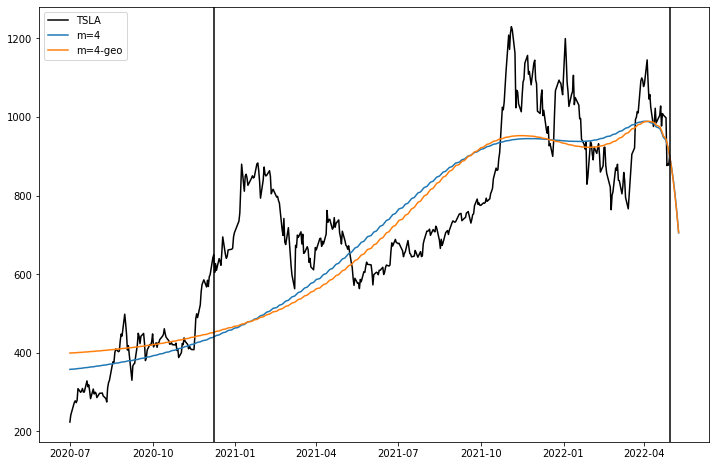

In [5]:
marketplot('tsla', [4], period=350, start_date='20200701', forecast=10)

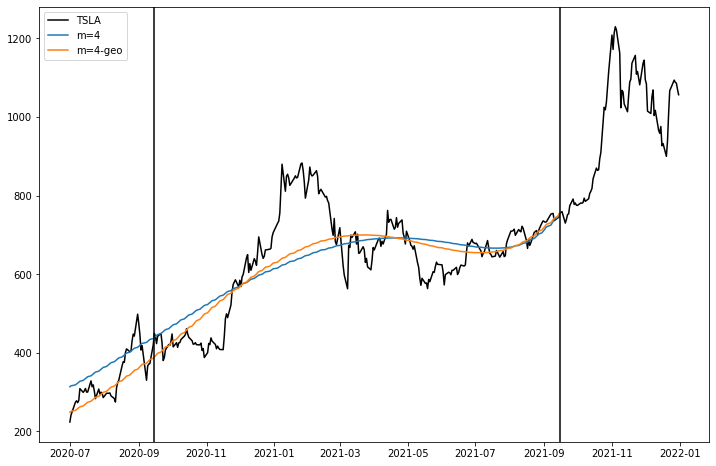

In [6]:
marketplot('tsla', [4], period=252, h=80, start_date='20200701', t0_date='20210915', end_date='20211231')

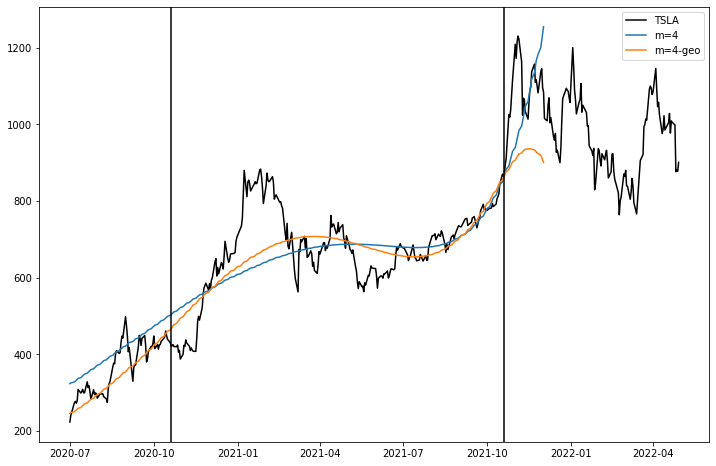

In [7]:
marketplot('tsla', [4], period=252, h=80, start_date='20200701', t0_date='20211020', forecast=30)

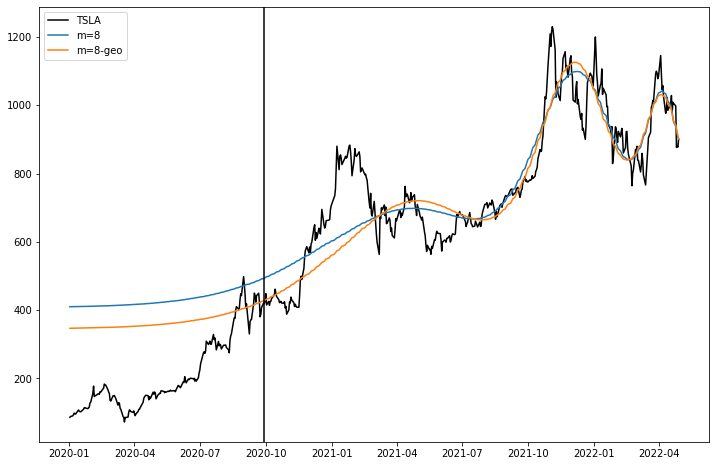

In [8]:
marketplot('tsla', [8], period=400, start_date='20200101', file='tsla')